In [1]:
import numpy as np
import itertools
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_yago39k
from ampligraph.latent_features.models import TransE, ComplEx

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
X = load_yago39k()

In [4]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [5]:
model = TransE(batches_count=64, seed=0, epochs=1000, k=100, eta=20,
               optimizer='adam', optimizer_params={'lr':0.0001},
               loss='nll', verbose=False)

model.fit(X['train'])

In [6]:
import sys
sys.path.append("..")

from generate_corruptions import generate_corruptions

In [7]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [8]:
scores = model.predict(X['test'])

model.calibrate(X_valid_pos, batches_count=10, epochs=100, positive_base_rate=0.5)
probas1 = model.predict_proba(X['test'])

model.calibrate(X_valid_pos, X_valid_neg, batches_count=10, epochs=100)
probas2 = model.predict_proba(X['test'])

In [9]:
val_scores = model.predict(X['valid'])

In [10]:
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
probas3 = ir.predict(np.squeeze(scores).astype(float))

In [11]:
sc = _SigmoidCalibration()
sc.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
probas4 = sc.predict(np.squeeze(scores).astype(float))

In [13]:
import types
model.generate_corruptions = types.MethodType(generate_corruptions, model)
corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
val_pos_scores = np.squeeze(model.predict(X_valid_pos))
iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
probas5 = iso_pos.predict(np.squeeze(scores).astype(float))

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

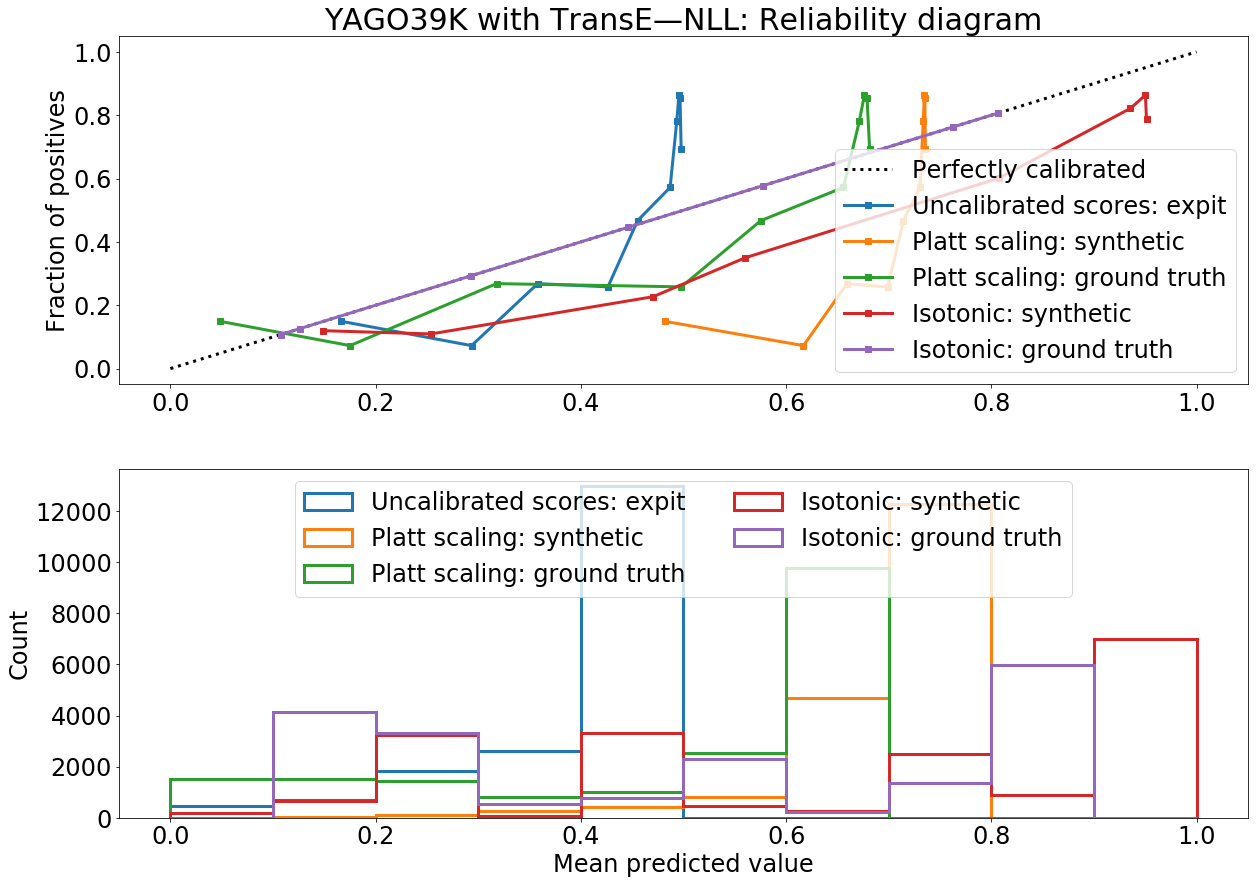

In [15]:
plt.rcParams.update({'font.size': 24, 'axes.titlesize': 30})

fig = plt.figure(figsize=(18, 18))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
ax2 = plt.subplot2grid((3, 1), (1, 0))

ax1.plot([0, 1], [0, 1], "k:", lw=3, label="Perfectly calibrated")
#ax1.grid()

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                expit(scores), n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Uncalibrated scores: expit")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                probas1, n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Platt scaling: synthetic")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                probas2, n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Platt scaling: ground truth")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                probas5, n_bins=8, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Isotonic: synthetic")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                probas3, n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Isotonic: ground truth")

# fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
#                                                                 probas4, n_bins=10, strategy="quantile")
# ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="calibration_pos_neg_sc")


ax2.hist(expit(scores), range=(0, 1), bins=10,
         histtype="step", lw=3, label="Uncalibrated scores: expit")

ax2.hist(probas1, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Platt scaling: synthetic")

ax2.hist(probas2, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Platt scaling: ground truth")

ax2.hist(probas5, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Isotonic: synthetic")

ax2.hist(probas3, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Isotonic: ground truth")

# ax2.hist(probas4, range=(0, 1), bins=10,
#          histtype="step", lw=2, label="calibration_pos_neg_sc")

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('YAGO39K with TransE—NLL: Reliability diagram')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


plt.tight_layout()